# Detección de desordenes de laringe a través del procesamiento de audio

En el presente notebook, buscamos implementar un modelo de machine learning que permita detectar el tipo de desorden de laringe en un paciente a través del procesamiento de una grabación de su voz, el cuál se presente como un método ambulatorio de mayor accesibilidad a comparación de una laringoscopia ([Voice Disorders - John Hopkins Medicine](https://www.hopkinsmedicine.org/health/conditions-and-diseases/voice-disorders))

### Librerías

Utilizaremos la librería [wfdb](https://wfdb.readthedocs.io/en/latest/) para trabajar con los archivos de Physionet (.dat, .hea) de manera más sencilla.

In [ ]:
!pip install -q wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 9.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wfdb

# VOICED Database

Esta base de datos de Physionet incluye 208 grabaciones de voz de pacientes, donde 150 han sido diagnosticadas por especialistas como "voz patológica", mientras que las restantes 58 corresponden a pacientes sanos. Adicionalmente, la base de datos contiene información extra como el género, edad, hábitos del día a día (e.g consumo de alcohol, dieta y si es fumador@), estado ocupacional, y el resultado de los cuestionarios *Voice Handicap Index (VHI)* y *Reflux Symptom Index (RSI)*. Podemos encontrar el dataset en Physionet como [VOICED Database](https://physionet.org/content/voiced/1.0.0/), publicado por Verde, L y Sannino, G en 2018.

In [ ]:
!wget -r -N -c -np -q https://physionet.org/files/voiced/1.0.0/

In [ ]:
%cd /content/physionet.org/files/voiced/1.0.0

/content/physionet.org/files/voiced/1.0.0


## Análisis del dataset

In [ ]:
# RECORDS contiene el nombre de cada muestra
with open('RECORDS') as file:
    names = [line.rstrip() for line in file]

Cargamos algunos ejemplos para visualizar la data descargada.

In [ ]:
data = {}
for i in range(3):
  data[names[i]] = wfdb.rdrecord(names[i])

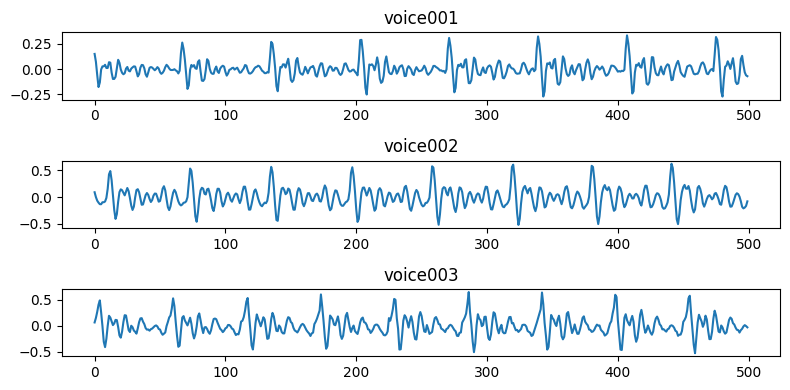

In [ ]:
# Visualización con matplotlib
fig, axs = plt.subplots(3, 1, figsize = (8,4))
for i in range(3): 
  wave = data[names[i]].p_signal
  axs[i].plot(wave[1000:1500])
  axs[i].set_title(names[i])

plt.tight_layout()
plt.show()

Las variables de nuestro interés son `p_signal`, que contiene los datos, `fs`, que corresponde a la frecuencia de muestreo, y `comments`, que contiene datos clínicos del paciente, incluyendo el diagnóstico.

In [ ]:
# Accedemos a la metadata
data['voice003'].__dict__

{'record_name': 'voice003',
 'n_sig': 1,
 'fs': 8000,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 38080,
 'base_time': None,
 'base_date': None,
 'comments': ['<age>: 34  <sex>: M <diagnoses>: hyperkinetic dysphonia <medications>: none'],
 'sig_name': ['voice'],
 'p_signal': array([[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        ...,
        [-0.07550049],
        [-0.19726562],
        [-0.21923828]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['voice003.dat'],
 'fmt': ['32'],
 'samps_per_frame': [1],
 'skew': [None],
 'byte_offset': [None],
 'adc_gain': [2553061012.0597],
 'baseline': [-215546975],
 'units': ['NU'],
 'adc_res': [0],
 'adc_zero': [0],
 'init_value': [-215546975],
 'checksum': [-21681],
 'block_size': [0]}

Adicionalmente, podemos escuchar el audio.

In [ ]:
from IPython.display import Audio
Audio(data['voice001'].p_signal.T, rate=data['voice001'].fs)

In [ ]:
Audio(data['voice002'].p_signal.T, rate=data['voice002'].fs)

Notamos la dificultad de reconocer cual muestra corresponde a un paciente sano y a uno con patología en las cuerdas buscales (salvo quizá por la diferencia en tono y timbre), mostrando así la importancia de utilizar modelos de aprendizaje automático para complementar el diagnóstico. En este caso, el primer audio corresponde a una patología (disfonia hiperquinética), mientras que el segundo audio corresponde a una muestra de paciente sano.

In [ ]:
annotation = data['voice001'].comments[0]

def obtain_metadata(annotation):
  a = annotation.split(':')
  for i in range(len(a)-1): a[i+1] = a[i+1][1:]
  comments = dict()
  for j in range(len(a)):
    if j == 0:
      comments[a[j][1:-1]] = np.nan
    elif j > 0 and j < len(a)-1:
      aux = a[j].split('<')
      comments[list(comments.keys())[j-1]] = aux[0].strip()
      comments[aux[1][:-1]] = np.nan 
    else:
      comments[list(comments.keys())[j-1]] = a[4]
  return(comments)

print(obtain_metadata(annotation))

{'age': '32', 'sex': 'M', 'diagnoses': 'hyperkinetic dysphonia', 'medications': 'none'}


Observamos que dentro de la variable `comments` podemos encontrar la edad, el sexo, el diagnóstico y las medicaciones del paciente en cuestión.

In [ ]:
# La base de datos tiene el score de dos cuestionarios
test = ['Voice Handicap Index (VHI) Score',
        'Reflux Symptom Index (RSI) Score']

# Los resultados están guardados en archivos de texto
with open('voice001-info.txt') as file:
  medical_test = [line.rstrip() for line in file]
scores = [
    sentence for sentence in medical_test if any(
        w.lower() in sentence.lower() for w in test
    )
]

print(scores)

['Voice Handicap Index (VHI) Score:\t15', 'Reflux Symptom Index (RSI) Score:\t5']


Por último, observamos que de la base de datos también podemos extraer información de los cuestionario VHI y RSI.

## Extracción de información

In [ ]:
# Obtenemos los resultados de cada cuestionario
with open('voice001-info.txt') as file:
  medical_test = [line.rstrip() for line in file]
scores = [
    sentence for sentence in medical_test if any(
        w.lower() in sentence.lower() for w in test
    )
]

print(scores)

['Voice Handicap Index (VHI) Score:\t15', 'Reflux Symptom Index (RSI) Score:\t5']


In [ ]:
with open('RECORDS') as file:
    names = [line.rstrip() for line in file]

test = ['Voice Handicap Index (VHI) Score',
        'Reflux Symptom Index (RSI) Score']

# Obtenemos todo el dataset
data = {}
for i in range(len(names)):
  data[names[i]] = wfdb.rdrecord(names[i])

# Guardamos los datos para su postprocesamiento
voice_samples = dict()
clinical_data = dict()
for voice in names:

  # Guardamos la voz del paciente 
  voice_samples[voice] = wfdb.rdrecord(voice).p_signal

  # Obtenemos la metadata
  comments = obtain_metadata(data[voice].comments[0])

  # Obtenemos la data de los scores
  with open(voice + '-info.txt') as file:
    medical_test = [line.rstrip() for line in file]
    scores = [
              sentence for sentence in medical_test if any(
                w.lower() in sentence.lower() for w in test)
              ]
  # Guardamos 

  clinical_data[voice] = (comments['diagnoses'], comments['age'], comments['medications'],
                          scores[0][scores[0].find('\t')+1:], scores[1][scores[1].find('\t')+1:])

clinical_data = pd.DataFrame.from_dict(clinical_data, orient = 'index', columns = ['Diagnosis', 'Age', 'Medications', 'VHI', 'RSI'])
clinical_data = clinical_data.reset_index(names = 'ID')

# Análisis exploratorio de datos

In [ ]:
clinical_data.dtypes

ID             object
Diagnosis      object
Age            object
Medications    object
VHI            object
RSI            object
dtype: object

Evaluamos si existe data faltante.

In [ ]:
np.sum(clinical_data.isnull())

ID             0
Diagnosis      0
Age            0
Medications    0
VHI            0
RSI            0
dtype: int64

Observamos las enfermedades asociadas a los pacientes con voces patológicas.

In [ ]:
clinical_data['Diagnosis'].value_counts()

hyperkinetic dysphonia    72
healthy                   57
hypokinetic dysphonia     40
reflux laryngitis         38
hyperkineti dysphonia      1
Name: Diagnosis, dtype: int64

Corregimos el error de sintaxis

In [ ]:
clinical_data['Diagnosis'] = clinical_data['Diagnosis'].replace('hyperkineti dysphonia','hyperkinetic dysphonia')
clinical_data['Diagnosis'].value_counts()

hyperkinetic dysphonia    73
healthy                   57
hypokinetic dysphonia     40
reflux laryngitis         38
Name: Diagnosis, dtype: int64

El diagnóstico de cada paciente nos servirá para la tarea de clasificación.

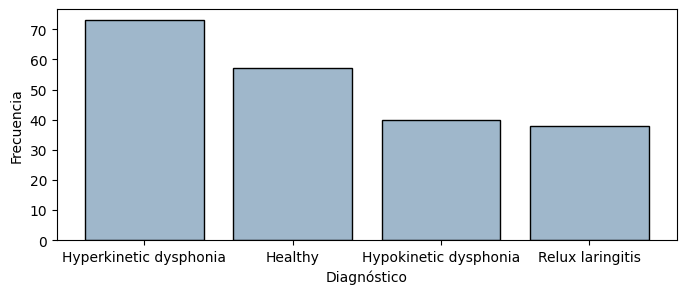

In [ ]:
plt.figure(figsize = (8,3))
dist = dict(clinical_data['Diagnosis'].value_counts())
plt.bar(range(len(dist.keys())), dist.values(), color = '#9fb7cb', edgecolor = 'black')
plt.xticks(range(len(dist.keys())), ['Hyperkinetic dysphonia', 'Healthy', 'Hypokinetic dysphonia', 'Relux laringitis'])
plt.xlabel('Diagnóstico')
plt.ylabel('Frecuencia')
plt.show()

Seguidamente,  convertimos los datos de edad y el resultado de los cuestionarios a variables de tipo numérico.

In [ ]:
clinical_data['Age'] = pd.to_numeric(clinical_data['Age'])
clinical_data['VHI'] = pd.to_numeric(clinical_data['VHI'])
clinical_data['RSI'] = pd.to_numeric(clinical_data['RSI'])
clinical_data.dtypes

ID             object
Diagnosis      object
Age             int64
Medications    object
VHI             int64
RSI             int64
dtype: object

Consideraremos los datos de edad para la implementación del algoritmo de clasificación entre una voz patológica y sana debido a que existe evidencia de que la laringe experimenta cambios estructurales relacionados a la edad ([Gregory et al, 2012](https://www.sciencedirect.com/science/article/abs/pii/S0892199710002171?casa_token=cXDdUiJ6eEgAAAAA:DkWPiuOVdHXRQej1j9igMdHkHJxA6nXmt35oqYk7u87lY5wYZY9ku3PFN9lkKcBne6HitlgZpvo)). 

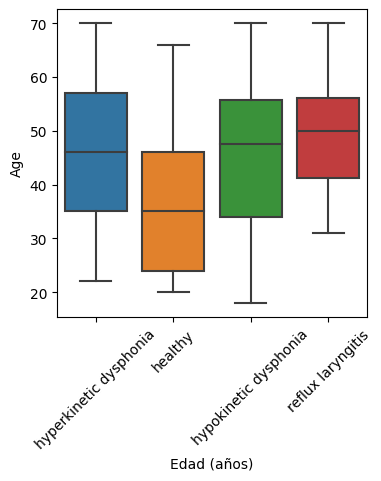

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (4,4))
ax = sns.boxplot(x='Diagnosis', y='Age', data=clinical_data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_xlabel('Edad (años)')
plt.show()

Asimismo, consideramos los resultados de los cuestionarios para la implementación del algoritmo de clasificación.

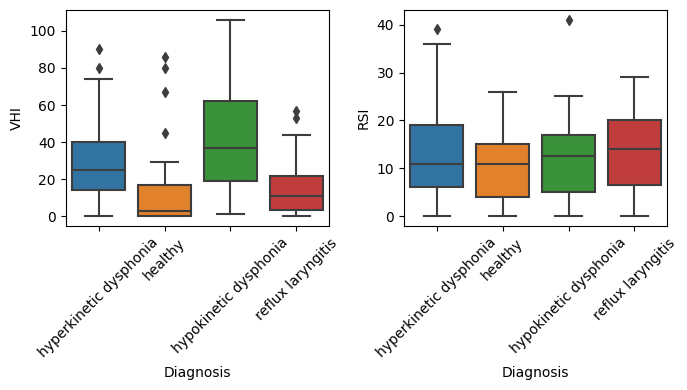

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (7,4))
sns.boxplot(x='Diagnosis', y='VHI', data=clinical_data, ax = ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=45)
sns.boxplot(x='Diagnosis', y='RSI', data=clinical_data, ax = ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=45)
plt.tight_layout()
plt.show()

En este caso, un resultado $\text{VHI} = 0$ o $\text{RSI} = 0$ son posibles, de acuerdo a la documentación de cada uno ([VHI](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8347778/) y [RSI](https://www.ijopl.com/doi/IJOPL/pdf/10.5005/jp-journals-10023-1141#:~:text=An%20RSI%20of%20more%20than,laryngeal%20findings%20related%20to%20LPR.)). Probablemente, un resultado $\text{VHI | RSI} = 0$ coincida con la cantidad de pacientes sanos.

In [ ]:
len(clinical_data['RSI'] == 0) == len(clinical_data['Diagnosis'] == 'healthy')

True

In [ ]:
len(clinical_data['VHI'] == 0) == len(clinical_data['Diagnosis'] == 'healthy')

True

Seguidamente, evaluamos las medicaciones prescritas a cada paciente.

In [ ]:
clinical_data['Medications'].value_counts()

none    208
Name: Medications, dtype: int64

Al no proveer de información relevante, descartaremos dicha columna.

In [ ]:
clinical_data = clinical_data.drop('Medications', axis = 1)

## Matriz de características

### Pitch

El timbre (o *pitch*) de la voz humana se determina por la tensión que ejercen las cuerdas bucales sobre la laringe ([Belyk et al, 2018](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6124115/#:~:text=Vocal%20pitch%20is%20determined%20by,set%20of%20'control%20rules'.)). Consideramos el cálculo de esta variable como un buen indicador de una voz patológica debido a que, tanto en disfonia hypoquinética e hiperquinética, las cuerdas bucales no pueden cerrarse por completo debido a la falta de tensión ([Barkmeier-Kraemer and Clark, 2017](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5628324/)). Hipotetizamos que este efecto se verá reflejado en el timbre de la voz de los pacientes.

Encontramos en la literatura que el cálculo del timbre puede ser realizado como $f_p = f_s / l$, donde $f_p$ es el timbre, $f_s$ es la frecuencia de muestreo de la señal de audio y $l$ es el valor de *lag* que corresponde al pico más alto al realizar una autocorrelación.
Sin embargo, este método no se correpondía con lo esperado, suponemos que porque la voz humana es una señal no estacionaria ([Rabiner, 1997](https://web.ece.ucsb.edu/Faculty/Rabiner/ece259/Reprints/110_autocorrelation%20pitch.pdf)). Por lo tanto, terminamos utilizando la librería `crepe` que permite el cálculo del pitch. Este algoritmo ha mostrado mejor rendimiento que *pitch trackers* del estado del arte como pYIN  y SWIPE ([CREPE Pitch Tracker](https://github.com/marl/crepe))

In [ ]:
!pip install -q crepe

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.4/323.4 kB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.2/217.2 kB 28.7 MB/s eta 0:00:00


Realizaremos un ejemplo de aplicación.

In [ ]:
import crepe

# Omitimos el silencio (i.e donde la señal = 0) al inicio de la señal
aux = voice_samples['voice001'] == 0 
idx = np.where(aux == 0)
new_wave = voice_samples['voice001'][idx[0][0]:]

# Calculamos el timbre
time, frequency, confidence, activation = crepe.predict(new_wave, 8000, viterbi=True)
print(f'Timbre: {np.mean(frequency):.3f} ± {np.std(frequency):.3f}')

15/15 [==============================] - 11s 51ms/step
Timbre: 112.773 ± 1.962


Incluimos el timbre de cada muestra en la matriz de features.

In [ ]:
pitch = []
for voice in names:
  aux = voice_samples[voice] == 0
  idx = np.where(aux == 0)
  new_wave = voice_samples[voice][idx[0][0]:]

  time, frequency, confidence, _ = crepe.predict(new_wave, 8000, viterbi = True, verbose = False)
  pitch.append(np.mean(frequency))

In [ ]:
clinical_data.insert(np.shape(clinical_data)[1], 'Pitch', pitch)

In [ ]:
clinical_data

,ID,Diagnosis,Age,VHI,RSI,Pitch
0,voice001,hyperkinetic dysphonia,32,15,5,112.773247
1,voice002,healthy,55,17,12,128.312863
2,voice003,hyperkinetic dysphonia,34,42,26,144.199786
3,voice004,hypokinetic dysphonia,28,20,9,191.314835
4,voice005,hypokinetic dysphonia,54,39,23,163.917800
...,...,...,...,...,...,...
203,voice204,healthy,59,0,7,246.506884
204,voice205,hyperkinetic dysphonia,30,62,19,219.801132
205,voice206,healthy,22,0,6,369.247317
206,voice207,healthy,30,0,26,193.839712


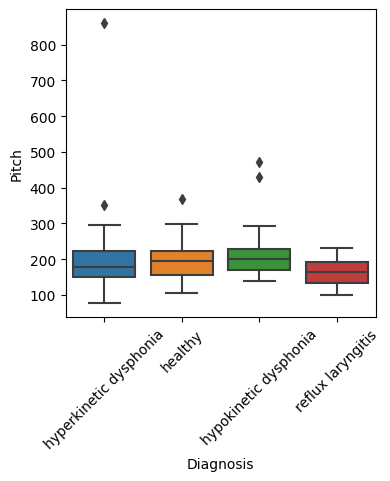

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (4,4))
ax = sns.boxplot(x='Diagnosis', y='Pitch', data=clinical_data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

### Envolvente y frecuencia instantánea

En base a la extracción de features propuesta por [Chen et al (2021)](https://www.sciencedirect.com/science/article/abs/pii/S0892199720301016), calculamos la amplitud promedio de la señal envolvente a la voz, así como la frecuencia instantánea, utilizando para ello la transformada de Hilbert.

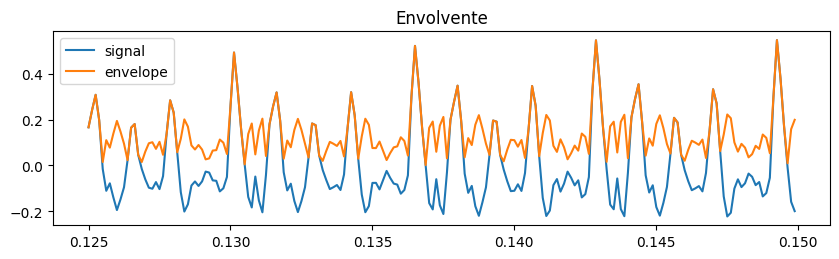

In [ ]:
# Adaptado de scipy.signal.hilbert - Scipy Docs
from scipy.signal import hilbert

fs = 8000
signal = voice_samples['voice032']
t = np.arange(len(signal)) / fs

# Calculamos la señal analítica
analytic_signal = hilbert(signal)

# Extraemos la envolvente
amplitude_envelope = np.abs(analytic_signal)

# así como la fase instantánea
instantaneous_phase = np.unwrap(np.angle(analytic_signal))

# Visualizamos 
fig, ax0 = plt.subplots(nrows=1, figsize = (8.5,2.7))

ax0.plot(t[1000:1200], signal[1000:1200], label='signal')
ax0.plot(t[1000:1200], amplitude_envelope[1000:1200], label='envelope')
ax0.set_title('Envolvente')
ax0.legend()

fig.tight_layout()

In [ ]:
envelope = []
phase = []
fs = 8000

for voice in names:
  signal = voice_samples[voice]
  analytic_signal = hilbert(signal)

  # Extraemos la envolvente
  amplitude_envelope = np.abs(analytic_signal)
  envelope.append(np.mean(amplitude_envelope))

  # Extraemos la fase
  instantaneous_phase = np.unwrap(np.angle(analytic_signal))
  phase.append(np.mean(instantaneous_phase))

In [ ]:
clinical_data.insert(np.shape(clinical_data)[1], 'Envelope', envelope)
clinical_data.insert(np.shape(clinical_data)[1], 'Phase', phase)

In [ ]:
clinical_data

,ID,Diagnosis,Age,VHI,RSI,Pitch,Envelope,Phase
0,voice001,hyperkinetic dysphonia,32,15,5,112.773247,0.087299,-1.788678
1,voice002,healthy,55,17,12,128.312863,0.225023,-1.505291
2,voice003,hyperkinetic dysphonia,34,42,26,144.199786,0.189697,-1.735301
3,voice004,hypokinetic dysphonia,28,20,9,191.314835,0.042385,-1.467837
4,voice005,hypokinetic dysphonia,54,39,23,163.917800,0.145574,-1.597196
...,...,...,...,...,...,...,...,...
203,voice204,healthy,59,0,7,246.506884,0.109721,-1.740498
204,voice205,hyperkinetic dysphonia,30,62,19,219.801132,0.173719,-1.642159
205,voice206,healthy,22,0,6,369.247317,0.250773,-1.735383
206,voice207,healthy,30,0,26,193.839712,0.172781,-1.641829


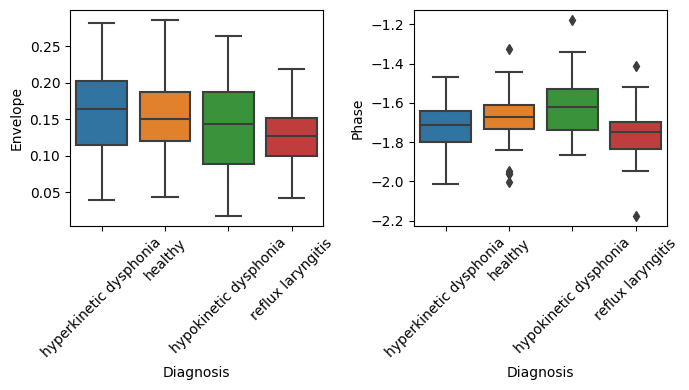

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (7,4))
sns.boxplot(x='Diagnosis', y='Envelope', data=clinical_data, ax = ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=45)
sns.boxplot(x='Diagnosis', y='Phase', data=clinical_data, ax = ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=45)
plt.tight_layout()
plt.show()

Finalmente, guardamos la matriz de características en formato .csv para implementar los modelos de aprendizaje automático en otro notebook.

In [ ]:
clinical_data.to_csv('speech_recognition.csv')
!cp speech_recognition.csv "/content/physionet.org"

cp: 'speech_recognition.csv' and '/content/physionet.org/speech_recognition.csv' are the same file
